# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [8]:
from cs231n.classifiers.softmax import softmax_loss_naive
res = softmax_loss_naive(np.random.randn(4, 3) * 0.0001,np.array(range(12)).reshape(3,4),np.array([1,0,2]),0.0)[0]
print(res,np.log(3))

1.0984199415910838 1.0986122886681098


In [11]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

(10,) [0.11766083 0.08126857 0.12138616 0.08192335 0.10542946 0.09619072
 0.07047277 0.11153928 0.10880419 0.10532465]
loss: 2.325271
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ since all weights are ~ 0, then we expect the numerator of the softmax func to be e^0=1, and the denominator to be sum(C*e^0), i.e. 1/C, which in our case is 1/10, or 0.1.



In [24]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.750519 analytic: -3.750519, relative error: 6.205282e-10
numerical: 0.339082 analytic: 0.339082, relative error: 2.730187e-08
numerical: 0.503999 analytic: 0.503999, relative error: 1.732700e-08
numerical: 0.416059 analytic: 0.416059, relative error: 4.421243e-08
numerical: 1.181099 analytic: 1.181099, relative error: 6.529893e-09
numerical: 2.596277 analytic: 2.596277, relative error: 2.972373e-08
numerical: 0.093261 analytic: 0.093261, relative error: 3.212049e-08
numerical: -1.001618 analytic: -1.001618, relative error: 4.607459e-08
numerical: 2.630233 analytic: 2.630233, relative error: 2.100523e-08
numerical: 0.814361 analytic: 0.814361, relative error: 3.406478e-08
numerical: -1.494097 analytic: -1.494097, relative error: 1.096357e-08
numerical: 0.299436 analytic: 0.299436, relative error: 7.324239e-09
numerical: 1.010525 analytic: 1.010525, relative error: 6.305878e-08
numerical: 0.647121 analytic: 0.647121, relative error: 2.124120e-08
numerical: -0.198662 analyti

In [39]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.325271e+00 computed in 0.385527s
vectorized loss: 2.325271e+00 computed in 0.008956s
Loss difference: 0.000000
Gradient difference: 0.000000


In [46]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7]
regularization_strengths = np.linspace(1.6e4, 1.7e4,num=10)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_lr = 0
best_rs = 0
for lr in learning_rates:
    for rs in regularization_strengths:
        sm = Softmax()
        print('learning rate: ',lr,'\nreg: ',rs)
        sm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500)
        acc_train = sm.accuracy(X_train,y_train)
        acc_val = sm.accuracy(X_val,y_val)
        results[(lr,rs)] = (acc_train,acc_val)
        print('acc: ',acc_val)
        if acc_val > best_val:
            best_val = acc_val 
            best_softmax = sm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate:  1e-07 
reg:  16000.0
acc:  0.36
learning rate:  1e-07 
reg:  16111.111111111111
acc:  0.365
learning rate:  1e-07 
reg:  16222.222222222223
acc:  0.354
learning rate:  1e-07 
reg:  16333.333333333334
acc:  0.351
learning rate:  1e-07 
reg:  16444.444444444445
acc:  0.353
learning rate:  1e-07 
reg:  16555.555555555555
acc:  0.354
learning rate:  1e-07 
reg:  16666.666666666668
acc:  0.354
learning rate:  1e-07 
reg:  16777.777777777777
acc:  0.353
learning rate:  1e-07 
reg:  16888.88888888889
acc:  0.361
learning rate:  1e-07 
reg:  17000.0
acc:  0.346
lr 1.000000e-07 reg 1.600000e+04 train accuracy: 0.342633 val accuracy: 0.360000
lr 1.000000e-07 reg 1.611111e+04 train accuracy: 0.343449 val accuracy: 0.365000
lr 1.000000e-07 reg 1.622222e+04 train accuracy: 0.345122 val accuracy: 0.354000
lr 1.000000e-07 reg 1.633333e+04 train accuracy: 0.340735 val accuracy: 0.351000
lr 1.000000e-07 reg 1.644444e+04 train accuracy: 0.344673 val accuracy: 0.353000
lr 1.000000e-07 reg

In [47]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.362000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ If the datapoint scores sufficiently high in one of the classes relative to the other ones, the SVM loss for that datapoint would be 0. whereas in Softmax, where the "probabilities" of each class are compared, no score would ever be 0, as that would require the score of one of the classes to be infinitely large compared to the other classes.



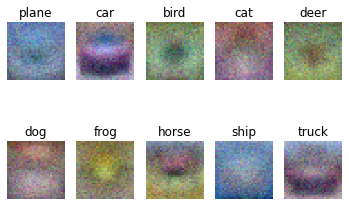

In [48]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])